In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from torchvision import datasets, transforms

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


LABEL THE OUTPUT AND SPECIFY FILES DIRECTORY

In [3]:
label = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5 }
pred_dir = "/content/drive/MyDrive/AI/Project/seg_pred/seg_pred"
train_dir = "/content/drive/MyDrive/AI/Project/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/AI/Project/seg_test/seg_test"

FUNCTIONS USED

In [4]:
def train_val_split_indices(n, portion):
    n_val = int(n * portion)
    idx = np.random.permutation(n)
    return idx[n_val:], idx[:n_val]

def show_image(image, label):
    ax = plt.gca()
    #hide x-axis
    ax.get_xaxis().set_visible(False)
    #hide y-axis 
    ax.get_yaxis().set_visible(False)
    print(f"Label: ", dataset.classes[label], f"({label})")
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.show()


def show_batch_images(data):
    for images, label in data:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images, nrow=10, padding = 15).permute(1,2,0))
        break

def accuracy(outputs, labels):
    _, pred = torch.max(outputs, 1)
    return torch.sum(pred==labels).item() / len(pred)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def loss_batch(model, loss_func, x, y, opt=None, metric=None):
    # Generate predictions
    x = x.to(device)
    y = y.to(device)
    preds = model(x)
    # Calculate loss
    loss = loss_func(preds,y)

    if opt is not None:
        # Compute gradients 
        loss.backward()
        # Changing parameters
        opt.step()
        # Reset gradient
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, y)

    return loss.item(), len(x), metric_result

def evaluate(model, loss_func, valid_dl, metric= None):
    with torch.no_grad():
        result = [loss_batch(model, loss_func, x, y, opt=None, metric=metric) for x, y in valid_dl]
        
        losses, nums, metrics = zip(*result)
        
        total = np.sum(nums)

        avg_loss = np.sum(np.multiply(losses, nums)) / total 
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total 
    return avg_loss, total, avg_metric
    


def train_model(model, epochs, loss_func, train, valid, opt_func, lr, metric=None):
    start = time.time()
    train_losses, val_losses, train_metrics, val_metrics = [], [], [], []
    #Set optimizer
    opt = opt_func(model.parameters(), lr=lr, weight_decay = 7e-4)

    for epoch in range(epochs):
        # Training
        model.train()
        for x, y in train:
            train_loss,_, train_accuracy = loss_batch(model, loss_func, x, y, opt, metric)
            
        # Evaluation
        model.eval()
        result = evaluate(model, loss_func, valid, metric)
        val_loss, total, val_accuracy = result

        # Record the accuracy
        train_losses.append(train_loss)
        train_metrics.append(train_accuracy)
        val_losses.append(val_loss)
        val_metrics.append(val_accuracy)

        # Printing the result
        if metric == None: 
            print("Epoch [{}/{}], train_loss: {:4f}, val_loss: {:4f}"
              .format(epoch+1, epochs, train_loss, val_loss))
        else:
          if epoch+1<10:
            print("Epoch [0{}/{}], train_loss: {:4f}, val_loss: {:4f}, train_{}: {:4f}, val_{}: {:4f}"
              .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, train_accuracy, metric.__name__, val_accuracy))
          else:
            print("Epoch [{}/{}], train_loss: {:4f}, val_loss: {:4f}, train_{}: {:4f}, val_{}: {:4f}"
              .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, train_accuracy, metric.__name__, val_accuracy))
             
    print(f"Training complete. Training takes {(time.time() - start)/60:,.2f}mins")
             
    return train_losses, val_losses, train_metrics, val_metrics


cuda
torch.Size([3, 150, 150])
Label:  buildings (0)


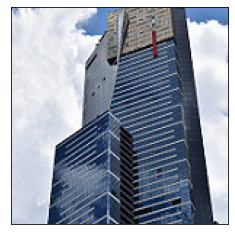

In [5]:
transform = transforms.Compose([transforms.Resize((150,150)),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(train_dir, transform = transform)
test_set = datasets.ImageFolder(test_dir, transform = transform)
# Get device for the training
device = get_device()
print(device)

print(test_set[0][0].shape)

# Show an image of a test set
show_image(*test_set[0]) 


{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of training images is: 11929
Number of validating images is: 2105


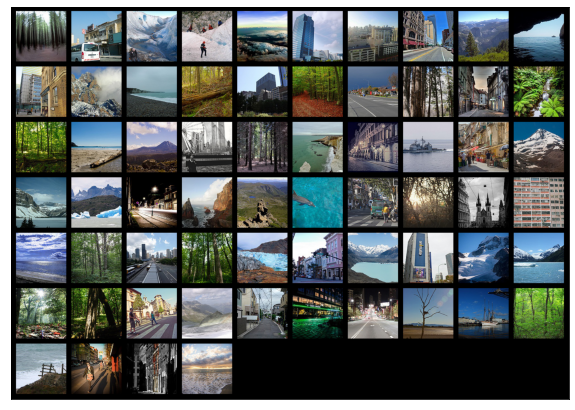

In [6]:
#Spliting dataset into training and validating 
train_indices, valid_indices = train_val_split_indices(len(dataset), 0.15)
print(dataset.class_to_idx)
print(f"""Number of training images is: {len(train_indices)}
Number of validating images is: {len(valid_indices)}""")

#Creating training loader
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size= 64, sampler= train_sampler)

#Creating validation loader
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)
val_loader = torch.utils.data.DataLoader(dataset, batch_size= 64, sampler= val_sampler)

#Show some training batch
show_batch_images(train_loader)

MODEL REPRESENTATION

In [7]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048,6)
no_epochs = 25
lr = 0.001
# Move model to GPU
model = model.to(device)

# Initiate the loss function 
loss = nn.CrossEntropyLoss()

# Initiate the optimizer
optimizer = torch.optim.SGD

train_loss, val_loss, train_acc, val_acc = train_model(model, no_epochs, loss, train_loader, val_loader, optimizer, lr, metric= accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch [01/25], train_loss: 0.743475, val_loss: 0.701608, train_accuracy: 0.840000, val_accuracy: 0.873159
Epoch [02/25], train_loss: 0.427776, val_loss: 0.407482, train_accuracy: 0.960000, val_accuracy: 0.904038
Epoch [03/25], train_loss: 0.251543, val_loss: 0.306608, train_accuracy: 0.960000, val_accuracy: 0.914489
Epoch [04/25], train_loss: 0.418703, val_loss: 0.265685, train_accuracy: 0.840000, val_accuracy: 0.919715
Epoch [05/25], train_loss: 0.210555, val_loss: 0.241510, train_accuracy: 0.960000, val_accuracy: 0.927791
Epoch [06/25], train_loss: 0.264424, val_loss: 0.226232, train_accuracy: 0.880000, val_accuracy: 0.932542
Epoch [07/25], train_loss: 0.241467, val_loss: 0.214484, train_accuracy: 0.960000, val_accuracy: 0.937292
Epoch [08/25], train_loss: 0.514574, val_loss: 0.204593, train_accuracy: 0.840000, val_accuracy: 0.936342
Epoch [09/25], train_loss: 0.053298, val_loss: 0.201634, train_accuracy: 1.000000, val_accuracy: 0.941093
Epoch [10/25], train_loss: 0.031973, val_loss:

PLOTTING VALIDATION AND TRAINING ACCURACY

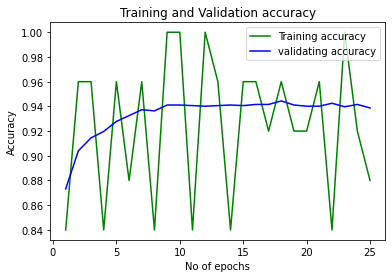

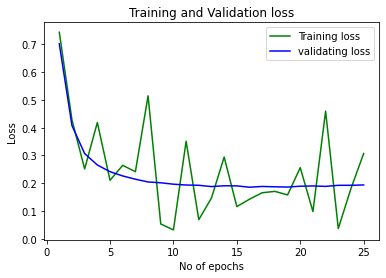

In [8]:
epochs = range(1, len(val_acc)+1)
plt.plot(epochs, train_acc, "g", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="validating accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("No of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("")
#Loss value
plt.plot(epochs, train_loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "b", label="validating loss")
plt.title("Training and Validation loss")
plt.xlabel("No of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

PREDICT SOME IMAGES FROM PREDICITON SET

In [9]:
#Test the accuracy
r = list(range(len(test_set)))
pred = 0
for i in r:
  test_image = test_set[i][0].unsqueeze(0).to(device)
  if dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(test_image)))] == dataset.classes[test_set[i][1]]:
    pred = pred + 1
print("The accuracy on the test set is: {:4f}".format(pred/len(test_set)))

The accuracy on the test set is: 0.925667


In [10]:
pred_dir = "/content/drive/MyDrive/AI/Project/seg_pred"
pred_set = datasets.ImageFolder(pred_dir, transform = transform)

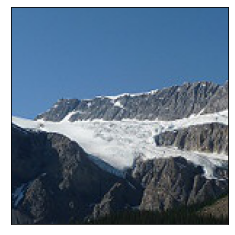

Prediction is: glacier


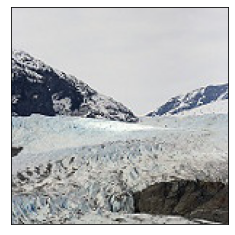

Prediction is: glacier


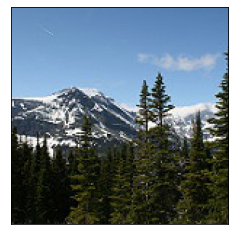

Prediction is: mountain


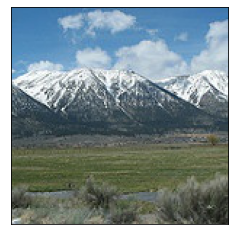

Prediction is: mountain


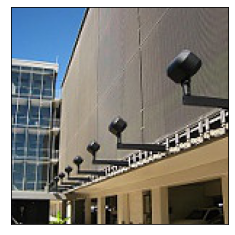

Prediction is: buildings


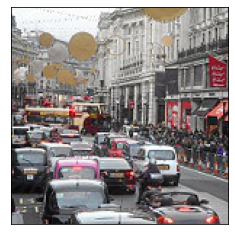

Prediction is: street


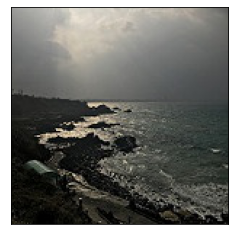

Prediction is: sea


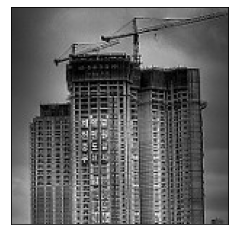

Prediction is: buildings


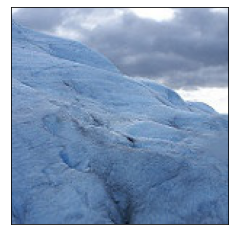

Prediction is: glacier


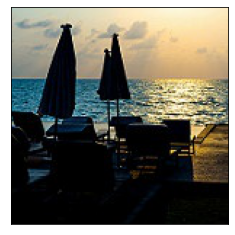

Prediction is: sea


In [11]:
# Randomize the index
r = list(range(len(pred_set)))
np.random.shuffle(r)
# stop = 0

for i in range(10):
  ax = plt.gca()
  #hide x-axis
  ax.get_xaxis().set_visible(False)
  #hide y-axis 
  ax.get_yaxis().set_visible(False)
  image = (pred_set[r[i]][0].unsqueeze(0).to(device))
  plt.imshow(pred_set[r[i]][0].permute(1,2,0))
  plt.show()
  print("Prediction is:", dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(image)))])

CHECK THE PERFORMANCE OF THE MODEL ON TESTSET

Image 1
Label:  mountain (3)


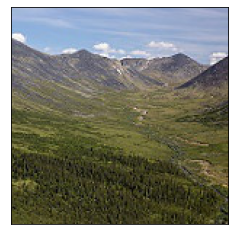

Prediction is: mountain
Image 2
Label:  forest (1)


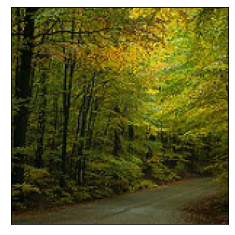

Prediction is: forest
Image 3
Label:  forest (1)


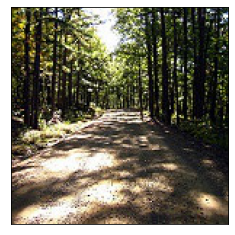

Prediction is: forest
Image 4
Label:  buildings (0)


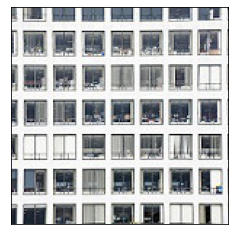

Prediction is: buildings
Image 5
Label:  sea (4)


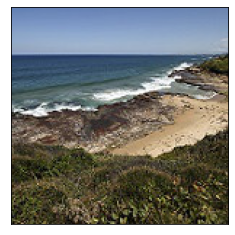

Prediction is: sea
Image 6
Label:  mountain (3)


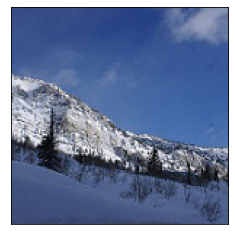

Prediction is: mountain
Image 7
Label:  buildings (0)


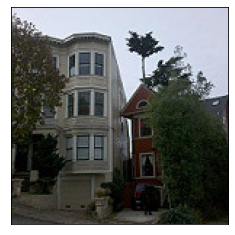

Prediction is: buildings
Image 8
Label:  street (5)


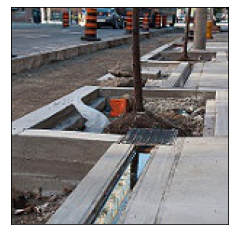

Prediction is: street
Image 9
Label:  forest (1)


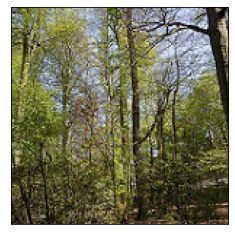

Prediction is: forest
Image 10
Label:  glacier (2)


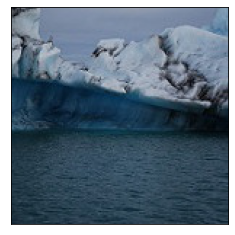

Prediction is: glacier


In [12]:
# Randomize the index
r = list(range(len(test_set)))
np.random.shuffle(r)
stop = 0

for i in r:
  print(f"Image {(stop + 1)}")
  show_image(*test_set[i])
  test_image = test_set[i][0].unsqueeze(0).to(device)
  print("Prediction is:", dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(test_image)))])
  stop += 1
  if stop == 10: 
    break

**Comment**

I accomplished figuring how to use the image classification architecture (provided through pytorch) and implemented the given training and validation data shared with me through https://www.kaggle.com/youssefalsoufi/cnn-for-image-classification.

I have achieved a validation accuracy of nearly 93 % after running parallel backpropagation gradient descent over a time period of 2 hours. 

To these efforts, I hope to improve the efficiency and accuracy of our prediction model while remaining it to not overfit if further training data is given.

